In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [2]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 20

## Full Dataset

In [3]:
protocols = np.array([59, 60, 82, 88, 89, 90, 95, 110, 123, 140, 156, 168, 180, 186, 201, 203, 208, 212, 225, 226, 241, 248])

In [ ]:
# We need to read data and transform the time column into datetime object
files = ['<sensor_id>']

data = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"../data/tpms-{f}.csv")
    df["time"] = pd.to_datetime(df["time"])
    df.set_index(["time"], inplace=True)
    df = df[df["protocol"].isin(protocols)]
    if data.empty:
        data = df
    else:
        data = pd.concat((data,df))

In [5]:
cars = pd.read_csv('../data/cars.csv')
cars_np = cars[['id1','id2','id3','id4','id5','id6','id7','id8']].to_numpy(dtype=str).flatten()
cars_np = cars_np[~(cars_np == 'nan')]

In [6]:
# # Threshold for minimum number of occurrences
# threshold = 1  # Adjust this number as needed

# # Group by 'id' and count occurrences
# id_counts = data.groupby("id").size().sort_values(ascending=False)

# # Filter IDs by the threshold
# filtered_ids = id_counts[id_counts >= threshold].index

# Filter the original DataFrame to keep only rows with these IDs
filtered = data[data["id"].isin(cars_np)].drop(["Unnamed: 0"], axis=1)
filtered.shape

(111903, 16)

## Filtered

In [7]:
files = 5
filtered = pd.read_csv(f'../share/tpms-merged-{files}.csv')
cars = pd.read_csv('../data/cars.csv')
cars_np = cars[['id1','id2','id3','id4']].to_numpy(dtype=str).flatten()
cars_np = cars_np[~(cars_np == 'nan')]
filtered.index = pd.to_datetime(filtered['time'])
filtered.shape

(111903, 17)

In [8]:
grouping_analysis = [['30S','30 sec.'],['1T','1 min.'],['2T','2 min.'],['5T','5 min.'], ['10T','10 min.'], ['1H','1 h.'], ['2H','2 h.'], ['5H','5 h.']]

In [9]:
selector = 1
grouping_time = grouping_analysis[selector][0]

# Group by time bins and 'id', and count occurrences
grouped = filtered.groupby([pd.Grouper(freq=grouping_time), 'id']).size().reset_index(name='count')

# Create pivot table
pivot_table = grouped.pivot_table(index='time', columns='id', values='count', fill_value=0).cumsum()
pivot_table = pivot_table.resample(grouping_analysis[selector][0]).last().ffill()

In [10]:
c1_fl = pivot_table.loc[:,'45CB5A75']
c1_fr = pivot_table.loc[:,'45C78786']
c4_fl = pivot_table.loc[:,'808E708']

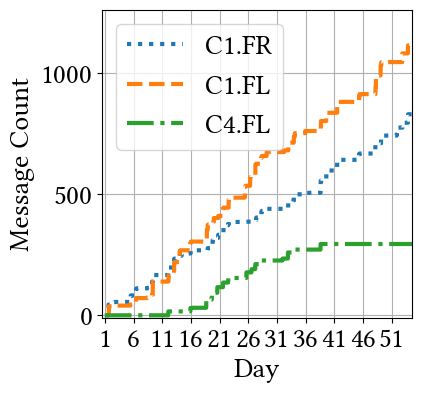

In [21]:
f, ax = plt.subplots(figsize=(4, 4))

ax.plot(range(len(c1_fl)), c1_fr, label='C1.FR', linestyle=':', linewidth=3.0)
ax.plot(range(len(c1_fl)), c1_fl, label='C1.FL', linestyle='--', linewidth=3.0)
ax.plot(range(len(c1_fl)), c4_fl, label='C4.FL', linestyle='-.', linewidth=3.0)

ax.set_xticks(np.linspace(0,len(c1_fl),len(c1_fl)//1440//5+1))
xt = ax.get_xticklabels()
ax.set_xticklabels(["{}".format(i*5 + 1) for (i,_) in enumerate(xt)])
ax.set_xlabel('Day')

ax.set_xlim([-.5*1440,56.5*1440])
ax.set_ylim([-10,1260])

ax.set_ylabel('Message Count')
ax.legend(ncol=1)

ax.grid()

plt.savefig('../pics/correlation/id_comparison_time.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [31]:
selector = 3
grouping_time = grouping_analysis[selector][0]

# Group by time bins and 'id', and count occurrences
grouped = filtered.groupby([pd.Grouper(freq=grouping_time), 'id']).size().reset_index(name='count')

# Create pivot table
pivot_table = grouped.pivot_table(index='time', columns='id', values='count', fill_value=0)

In [32]:
c1_fl = pivot_table.loc[:,'45CB5A75']
c1_fr = pivot_table.loc[:,'45C78786']
c4_fl = pivot_table.loc[:,'808E708']

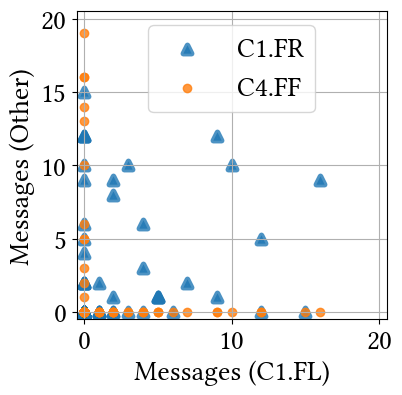

In [34]:
f, ax = plt.subplots(figsize=(4, 4))

ax.scatter(c1_fl, c1_fr, label='C1.FR', marker='^', alpha=.8, linewidth=4)
ax.scatter(c1_fl, c4_fl, label='C4.FF', marker='o', alpha=.8)

ax.set_xlim([-0.5,20.5])
ax.set_ylim([-0.5,20.5])

ax.grid()

ax.set_xlabel('Messages (C1.FL)')
ax.set_ylabel('Messages (Other)')

ax.legend(ncol=1,loc='upper center')

plt.savefig('../pics/correlation/id_comparison_against_one.pdf', format='pdf', bbox_inches='tight')
plt.show()